<a target="_blank" href="https://colab.research.google.com/github/vinicius-souza-lima/mvp_ml/blob/main/mvp_ml.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import kagglehub
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import kagglehub
import math
import fsspec

/home/vinicius/dev/mvp_ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problema de Regressão

## Problema de Classificação (Algoritmos Clássicos)

In [ ]:
class Dataset:
    def __init__(
        self,
        name: str,
        path_dir: str,
        resolution: tuple[int, int] = (128, 128),
    ):
        self.name = name
        self.data = None
        self.path_dir = path_dir
        self.resolution = resolution
        self.files = None
        self.X = None
        self.y = None

    def load_dataset(self):
        dir = Path(self.path_dir)
        files = dir.rglob("*.jpeg")
        self.files = files

    def convert_toarray(
        self,
        target_values: list[str],
        fallback: str | None = None,
    ):
        imgs = []
        targets = []

        for f in self.files:
            if f.is_dir():
                continue

            imgs.append(
                np.array(
                    Image.open(str(f))  # Lê a imagem
                    .convert("L")  # Converte para escala de cinza
                    .resize(
                        self.resolution, Image.Resampling.LANCZOS
                    )  # Redimensiona a imagem
                ).flatten()  # Formata a matriz como array
            )
            targets.append(
                next(
                    (cat for cat in f.name.split("_") if cat in target_values),
                    fallback,  # procura categoria no nome do arquivo
                )
            )

        return np.stack(imgs), np.array(targets).reshape((-1, 1))

    def save_converted(self, X: npt.ArrayLike, y: npt.ArrayLike) -> None:
        def dividir_array(X: npt.NDArray, max_size_mb=24):
            tam_x = X.nbytes
            tam_max = 1024 * 1024 * max_size_mb

            n_elem = math.ceil(tam_x / tam_max)
            return np.array_split(X, n_elem)

        cwd = Path(".")
        (cwd / "datasets").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}" / "X").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}" / "y").mkdir(exist_ok=True)

        data_path = cwd / "datasets" / f"{self.name}"

        for i, array in enumerate(dividir_array(X)):
            np.save(str(data_path / "X" / f"X_{i}"), array)  # Save x

        for i, array in enumerate(dividir_array(y)):
            np.save(str(data_path / "y" / f"y_{i}"), array)  # Save y

    @staticmethod
    def load_converted(path: str):
        X = []
        y = []
        path_x = Path(path) / "X"
        for file in sorted(path_x.glob("*")):
            X.append(np.load(str(file)))
        X = np.vstack(X)

        path_y = Path(path) / "y"
        for file in sorted(path_y.glob("*")):
            y.append(np.load(str(file)))
        y = np.vstack(y)

        return X, y.reshape((-1, 1))

    @staticmethod
    def download_from_remote(
        owner: str,
        repo: str,
        folder: str,
        destination: Path = Path("."),
    ):
        """
        Baixa pasta de repositório remoto do github de forma
        recursiva.
        """
        fs = fsspec.filesystem(protocol="github", org=owner, repo=repo)
        local_dir = destination / folder
        local_dir.mkdir(exist_ok=True, parents=True)
        fs.get(folder, local_dir.as_posix(), recursive=True)

Inicialmente foi usado o código abaixo para baixar o dataset de imagens do repositório do Kaggle

In [ ]:
""" 
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
path_chest = Path(path) / "chest_xray" / "chest_xray"
chest_data = Dataset("chest",path_chest,resolution=(128,128))
chest_data.load_dataset()
X_chest,y_chest = chest_data.convert_toarray(["bacteria","virus"],"normal")
chest_data.save_converted(X_chest,y_chest) 
"""

Nos usos subsequentes usou-se o dataset já armazenado no repositório remoto

In [ ]:
Dataset.download_from_remote("vinicius-souza-lima", "mvp_ml", "datasets")
X_chest, y_chest = Dataset.load_converted("datasets/chest")

In [61]:
resolution = (128, 128)

### Definição do Problema

Descrição do problema: Classificar imagem de raio x de paciente em saudável, pneumonia bacteriana ou pneumonia virótica

Premissas ou hipóteses sobre o problema

Restrições para selecionar os dados

Descrição do Dataset

In [58]:
X_chest.shape

(5856, 16384)

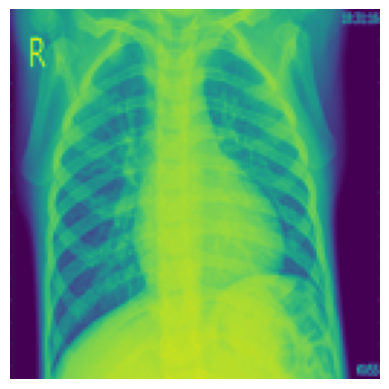

In [62]:
plt.imshow(X_chest[4000].reshape(resolution))
plt.axis("off")
plt.show()

### Preparação dos dados

#### Separação do Dataset em treino e teste

In [66]:
from sklearn.model_selection import KFold


X_chest_train, X_chest_test, y_chest_train, y_chest_test = train_test_split(
    X_chest, y_chest, test_size=0.2, random_state=42, stratify=y_chest
)

num_particoes = 5
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=42)

#### Data Augmentation

In [ ]:
class Augmenter(BaseEstimator, TransformerMixin):
    def __init__(
        self, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1
    ):
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        np.random.normal(0, 1, X.shape)

### Modelagem e treinamento

In [ ]:
np.random.seed(42)
results = []


models = {
    "NB": GaussianNB(),  # 5 sec
    "KNN": KNeighborsClassifier(),  # 12 sec
    "RF": RandomForestClassifier(),  # +- 3 min
    "CART": DecisionTreeClassifier(),  # +- 7 min
}

for name, model in models.items():
    cv_results = cross_val_score(
        model, X_chest_train, y_chest_train, cv=kfold, scoring="accuracy"
    )
    results.append(cv_results)
    np.save("results.npy", results)

    print(f"{name}: Média: {cv_results.mean():.2f}, std:{cv_results.std():.3f}")

NB: Média: 0.66, std:0.013
KNN: Média: 0.73, std:0.011
RF: Média: 0.78, std:0.013
CART: Média: 0.65, std:0.005


/tmp/ipykernel_336596/593571504.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names);


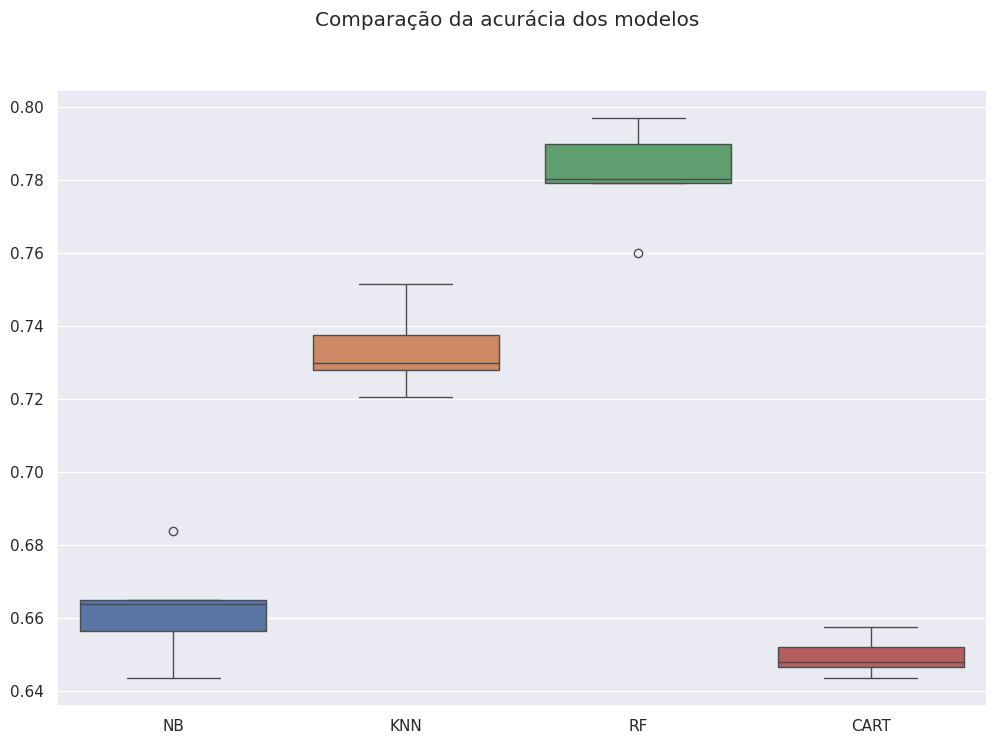

In [ ]:
sns.set_theme()
names = ["NB", "KNN", "RF", "CART"]
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Comparação da acurácia dos modelos")
ax.set_xticklabels(names)
sns.boxplot(results);

Assim foi escolhido Random Forest para prosseguir na otimização de hiperparâmetros

#### Otimização de Hiperparâmetros

In [37]:
model = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 2, 5, 10],
    "min_samples_split": [2, 4, 5],
    "min_samples_leaf": [2, 4, 5],
}

random_search = RandomizedSearchCV(
    model, param_grid, cv=3, scoring="accuracy", n_iter=5, n_jobs=2, random_state=42
)

In [51]:
random_search.fit(X_chest_train, y_chest_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [None, 2, 5, 10],
                                        'min_samples_leaf': [2, 4, 5],
                                        'min_samples_split': [2, 4, 5],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [54]:
random_search.best_score_

np.float64(0.7792497613757008)

In [56]:
final_model = random_search.best_estimator_

In [ ]:
joblib.dump(final_model, "final_model.joblib")

['final_model.joblib']

# Avaliação de Resultados

In [59]:
final_model = joblib.load("final_model.joblib")

In [ ]:
final_model.fit(X_chest_train, y_chest_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=200)

In [61]:
joblib.dump(final_model, "final_model.joblib")

['final_model.joblib']

### Métricas de Avaliação

#### Matriz de confusão

In [ ]:
y_chest_predict = cross_val_predict(final_model, X_chest_train, y_chest_train)

In [ ]:
cm = confusion_matrix()

#### Precisão e Recall

#### Curva ROC

## Problema de Visão Computacional (Deep Learning)

Objetivo: Treinar rede neural que classifique os tipos de tumores e segmente na imagem o local em que ele aparece

## Problema de Processamento de Linguagem Natural